# Burgers Equation UPINN

In [1]:
import torch
import sys
from scipy.stats import qmc # For hypercube sampling
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../utils')
from UPINN import UPINN
from Architectures import FNN
from Utils import RAD_sampler, SINDy_sklearn, SoftAdapt

Consider Burgers equation:

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

where $u(x,t)$ is the velocity field, $\nu$ is the viscosity coefficient, $x \in [-1,1]$ and $t \in [0,1]$. The initial condition is $u(x,0) = -\sin(\pi x)$ and the boundary conditions are $u(-1,t) = u(1,t) = 0$.

### Setup Boundary Value Problem

In [2]:
# Initial condition
N_ic = 100
u0 = lambda x: -torch.sin(torch.pi * x)
x0 = torch.linspace(-1, 1, N_ic)
t0 = torch.zeros_like(x0)
X0 = torch.stack((t0, x0), dim=-1)
U0 = u0(x0).reshape(-1, 1)

# Boundary condition
N_bc = 100
uL = lambda t: torch.zeros_like(t)
uR = lambda t: torch.zeros_like(t)
tL = torch.linspace(0, 1, N_bc)
tR = torch.linspace(0, 1, N_bc)
xL = -torch.ones_like(tL)
xR = torch.ones_like(tR)
XL = torch.stack((tL, xL), dim=-1)
XR = torch.stack((tR, xR), dim=-1)

# All boundary conditions
Xbc = torch.cat((XL, XR), dim=0)
Ubc = torch.cat((uL(tL).reshape(-1, 1), uR(tR).reshape(-1, 1)), dim=0)

In [3]:
# Collocation points
N_coll = 10000
sobol = torch.quasirandom.SobolEngine(dimension=2)
hypercube = qmc.LatinHypercube(d=2)
Xc = torch.tensor(hypercube.random(n=N_coll), dtype=torch.float32)
# Xc = sobol.draw(n=N_coll, dtype=torch.float32)
Xc[:, 1] = Xc[:, 1]*2 - 1

In [4]:
# Load data
data = np.load('../data/Burgers.npz')
tsol, xsol, usol = data['t'], data['x'], data['usol']

In [5]:
times = [0.0, 0.5, 0.75, 0.99]
times_idx = (np.array(times)*100).astype(int)

Xd = torch.tensor(np.vstack([np.hstack([t*np.ones_like(xsol.flatten()) for t in times]), np.tile(xsol.flatten(), len(times))]).T, dtype=torch.float32)
Ud = torch.concat([torch.tensor(usol[:, idx], dtype=torch.float32).reshape(-1, 1) for idx in times_idx], dim=0)

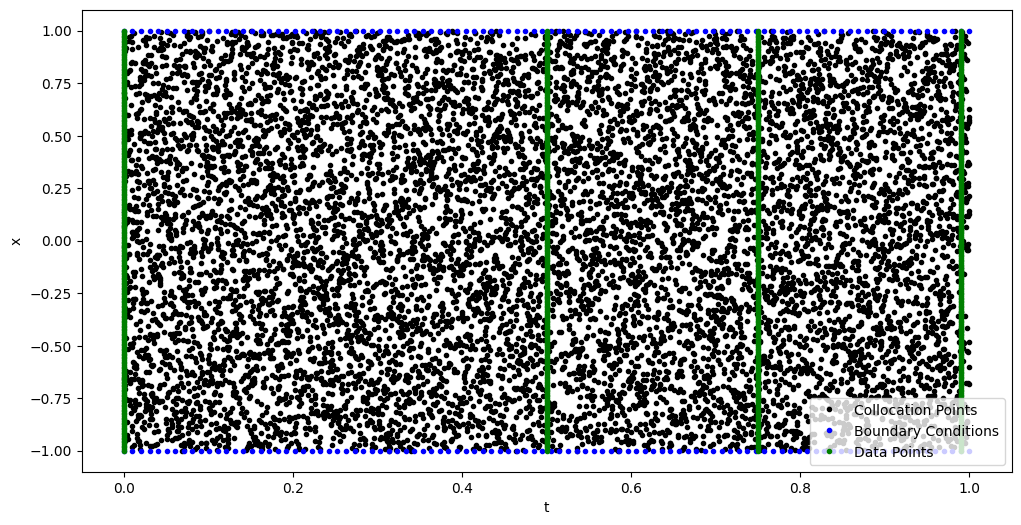

In [6]:
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(Xc[:, 0], Xc[:, 1], 'k.', label='Collocation Points')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(Xd[:, 0], Xd[:, 1], 'g.', label='Data Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Setup Boundary Value Problem

In [ ]:
class Burger(torch.nn.Module):
    def __init__(self, nu):
        super(Burger, self).__init__()
        self.nu = nu
    
    def forward(self, X, u):

        dudxt = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        u_t = dudxt[:,0:1]
        u_x = dudxt[:,1:2]
        
        u_xx = torch.autograd.grad(dudxt, X, torch.ones_like(dudxt), create_graph=True)[0][:,1:2]

        return u_t + u*u_x - self.nu*u_xx

### Initialize and train UPINN

In [8]:
def G_in(X, U):
    dudxt = torch.autograd.grad(U, X, torch.ones_like(U), create_graph=True)[0]
    u_t = dudxt[:,0:1]
    u_x = dudxt[:,1:2]
    return torch.cat((U, u_t, u_x), dim=-1)

class UPINN(UPINN):

    def refine_collocation_points(self):
        N = 50*N_coll
        D = N_coll
        k = 0.5
        c = 0.1

        Xc = sobol.draw(n=N, dtype=torch.float32)
        Xc[:, 1] = Xc[:, 1]*2 - 1
        Xc.requires_grad_(True)

        # Compute the residual
        u = self.u(Xc)
        G_input = G_in(Xc, u)
        # G_input = Xc
        # G_input = u
        # G_input = torch.cat((u, Xc), dim=-1)
        residual = abs(self.F(Xc, u) + self.G(G_input))
        
        self.collocation_points = RAD_sampler(Xc, residual, D, k, c)

    def pde_loss(self):
        U_c = self.u(self.collocation_points)
        G_input = G_in(self.collocation_points, U_c)
        # G_input = self.collocation_points
        # G_input = U_c
        # G_input = torch.cat((U_c, self.collocation_points), dim=-1)
        res = self.G(G_input)
        pde_loss = torch.nn.MSELoss()(self.F(self.collocation_points, U_c), res) if self.collocation_points.shape[0] > 0 else torch.tensor(0.0)
        return pde_loss
    

    def get_loss(self):
        bc_loss = self.bc_loss()
        data_loss = self.data_loss()
        pde_loss = self.pde_loss()
        # lambdas = SoftAdapt(beta=1.0)(torch.tensor([bc_loss, data_loss, pde_loss]))
        lambdas = torch.tensor([3.0, 5.0, 9.0])
        loss = lambdas[0]*bc_loss + lambdas[1]*data_loss + lambdas[2]*pde_loss
        return loss, bc_loss, data_loss, pde_loss

    def plot(self):
    
        # Get network prediction
        x_plot = np.linspace(-1, 1, 1000)
        t_plot = np.linspace(0, 1, 1000)
        T, X = np.meshgrid(t_plot, x_plot)
        T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
        X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
        z_plot = torch.cat((T_tensor, X_tensor), dim=-1)
        z_plot.requires_grad_(True)
        u_pred = self.u(z_plot)

        
        

        dudz_pred = torch.autograd.grad(u_pred, z_plot, torch.ones_like(u_pred), create_graph=True)[0]
        u_t_pred = dudz_pred[:, 0:1]
        u_x_pred = dudz_pred[:, 1:2]

        res_pred = self.G(torch.cat((u_pred, u_t_pred, u_x_pred), dim=-1))

        # Get the known solution
        dudx = np.gradient(usol, xsol.flatten(), axis=0)

        with torch.no_grad():
            
            u_pred = u_pred.reshape(1000, 1000).detach().numpy()
            u_t_pred = u_t_pred.reshape(1000, 1000).detach().numpy()
            u_x_pred = u_x_pred.reshape(1000, 1000).detach().numpy()
            res_pred = res_pred.reshape(1000, 1000).detach().numpy()

            plt.figure(figsize=(10, 3))

            # Slices of the predicted solution and the known solution
            plt.subplot(1, 2, 1)
            colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for the lines

            plt.plot(x_plot, u_pred[:, 0], label='t=0', color=colors[0])
            plt.plot(x_plot, u_pred[:, 250], label='t=0.25', color=colors[1])
            plt.plot(x_plot, u_pred[:, 500], label='t=0.5', color=colors[2])
            plt.plot(x_plot, u_pred[:, 750], label='t=0.75', color=colors[3])
            plt.plot(x_plot, u_pred[:, 999], label='t=1', color=colors[4])

            plt.plot(xsol, usol[:, 0], '--', color=colors[0])
            plt.plot(xsol, usol[:, 25], '--', color=colors[1])
            plt.plot(xsol, usol[:, 50], '--', color=colors[2])
            plt.plot(xsol, usol[:, 75], '--', color=colors[3])
            plt.plot(xsol, usol[:, 99], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('u')
            plt.legend()
            plt.title('Predicted Solution vs. Known Solution')


            # Slices of the predicted residuals and known residuals
            plt.subplot(1, 2, 2)

            plt.plot(x_plot[450:550], res_pred[450:550, 0], label='t=0', color=colors[0])
            plt.plot(x_plot[450:550], res_pred[450:550, 250], label='t=0.25', color=colors[1])
            plt.plot(x_plot[450:550], res_pred[450:550, 500], label='t=0.5', color=colors[2])
            plt.plot(x_plot[450:550], res_pred[450:550, 750], label='t=0.75', color=colors[3])
            plt.plot(x_plot[450:550], res_pred[450:550, 999], label='t=1', color=colors[4])

            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[0])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[1])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[2])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[3])
            plt.plot(xsol[115:140], -dudx[115:140, 75]*usol[115:140, 75], '--', color=colors[4])

            plt.xlabel('x'); plt.ylabel('Residual')
            plt.legend()
            plt.title('Predicted Residual vs. Known Residual')

            plt.tight_layout()
            plt.show()


            # Find the global vmin and vmax (same for all subplots)
            known_res = -dudx*usol
            exp_res = -u_x_pred*u_pred
            res_err = abs(res_pred - (exp_res))
            res_pred = res_pred

            plt.figure(figsize=(10, 8))

            vmin = min(usol.min(), u_pred.min())
            vmax = max(usol.max(), u_pred.max())

            # Known solution
            plt.subplot(3, 2, 1)
            plt.imshow(usol, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Solution')
            plt.colorbar()

            # Predicted solution
            plt.subplot(3, 2, 2)
            plt.imshow(u_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Solution')
            plt.colorbar()

            vmin = min(known_res.min(), exp_res.min(), res_err.min(), res_pred.min())
            vmax = max(known_res.max(), exp_res.max(), res_err.max(), res_pred.max())

            # Known residual
            plt.subplot(3, 2, 3)
            plt.imshow(known_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Known Residual')
            plt.colorbar()

            # Predicted residual
            plt.subplot(3, 2, 4)
            plt.imshow(res_pred, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Predicted Residual')
            plt.colorbar()

            # Expected residual
            plt.subplot(3, 2, 5)
            plt.imshow(exp_res, extent=(0, 1, -1, 1), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Expected Residual')
            plt.colorbar()

            # Residual error
            plt.subplot(3, 2, 6)
            plt.imshow(res_err, extent=(0, 1, -1, 1), origin='lower', aspect='auto')
            plt.xlabel('t'); plt.ylabel('x')
            plt.title('Residual Error')
            plt.colorbar()

            plt.tight_layout()
            plt.show()

In [9]:
# Define model architectures
hidden = [20] * 8

u = FNN(
    dims=[2, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

G = FNN(
    dims=[3, *hidden, 1],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Identity(),
)

nu = 0.01/torch.pi
F = SparseBurger(nu)

# Instantiate the UPINN
upinn = UPINN(u, F, G, boundary_points=(Xbc, Ubc), data_points=(Xd, Ud), collocation_points=Xc)

[Info]: Initializing UPINN model


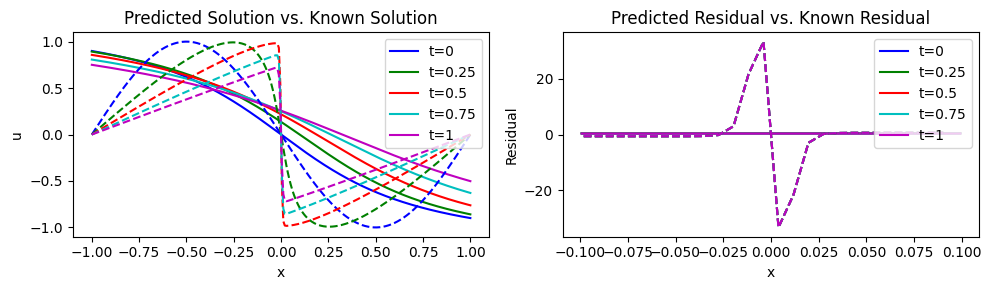

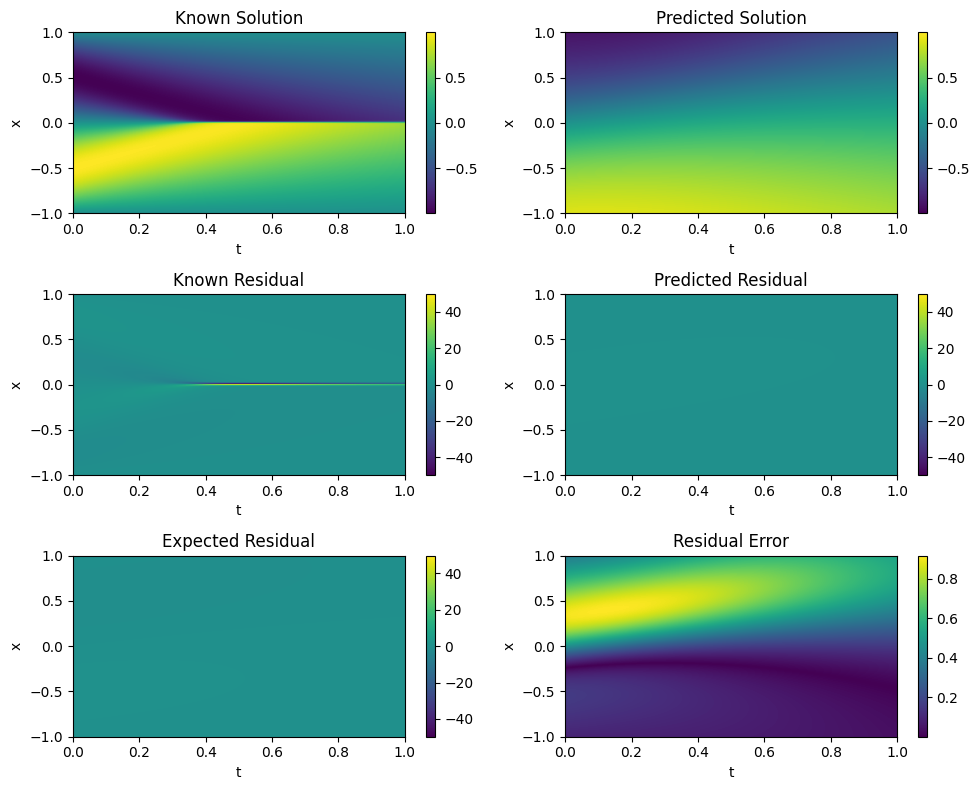

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:22<00:00, 43.54 epoch/s, L=7.15e-02, L_bc=2.38e-03, L_data=6.35e-03, L_pde=3.63e-03]


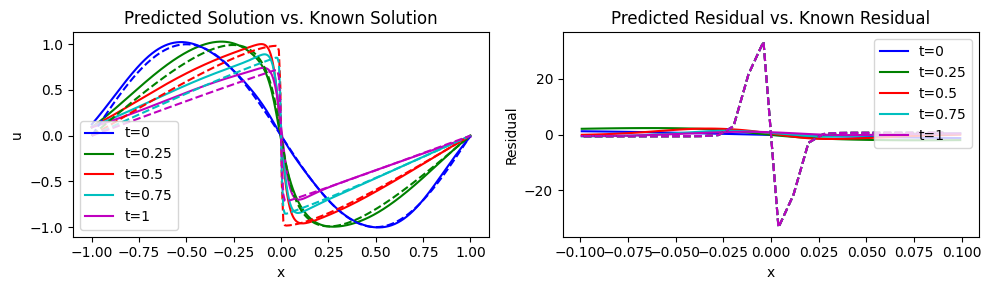

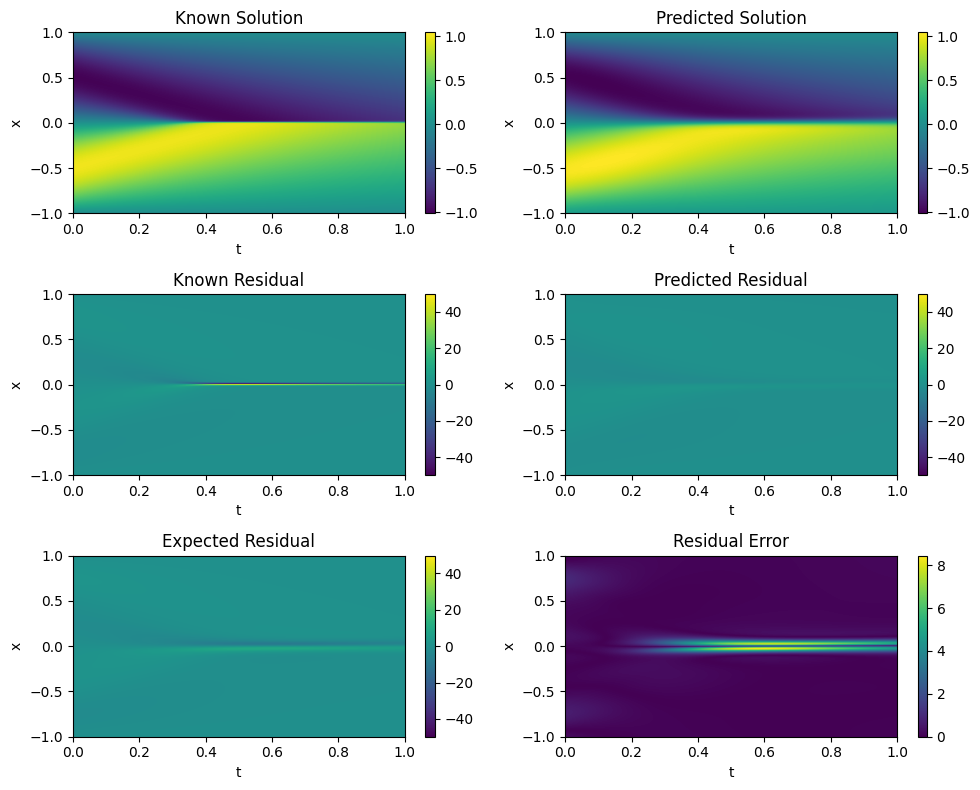

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:22<00:00, 44.18 epoch/s, L=1.76e-02, L_bc=1.48e-05, L_data=3.08e-03, L_pde=2.41e-04]


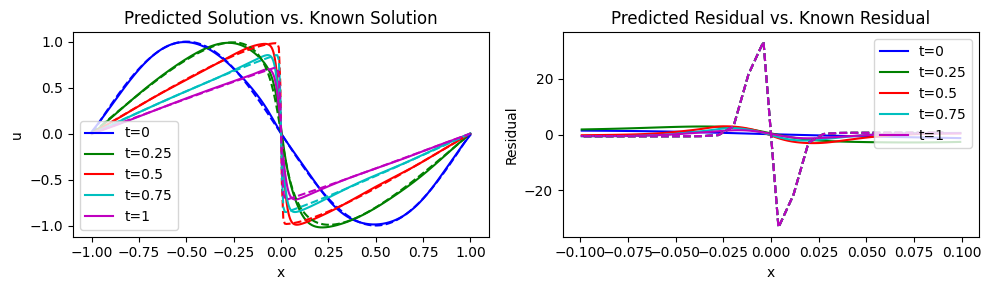

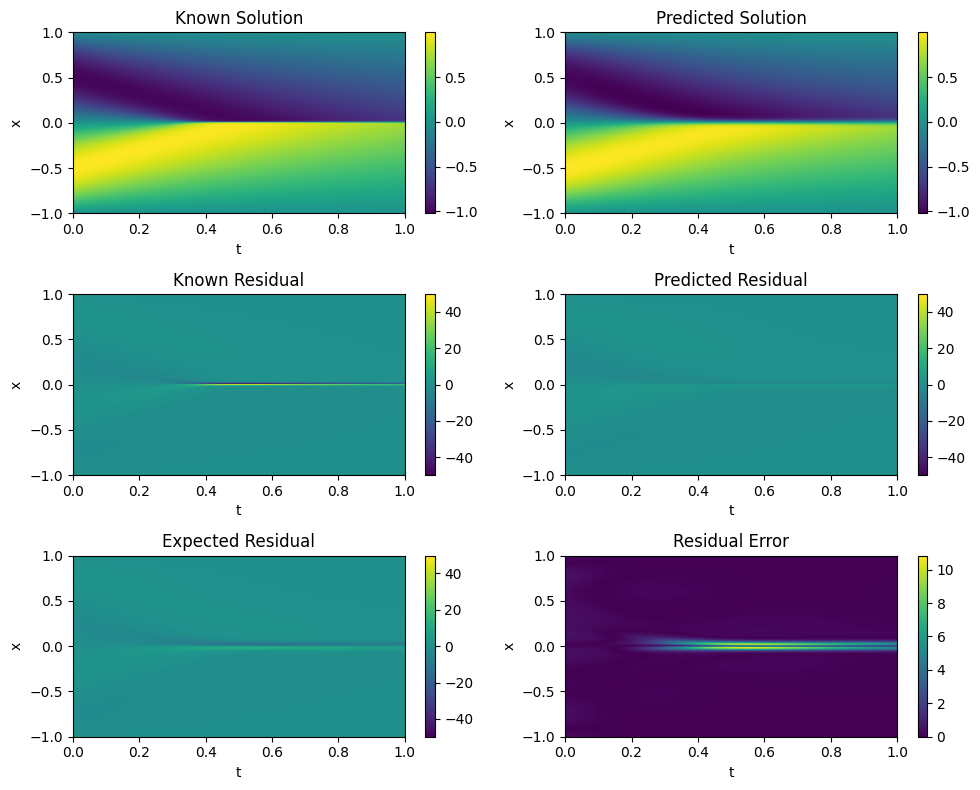

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:22<00:00, 43.88 epoch/s, L=1.27e-02, L_bc=7.90e-06, L_data=2.21e-03, L_pde=1.82e-04]


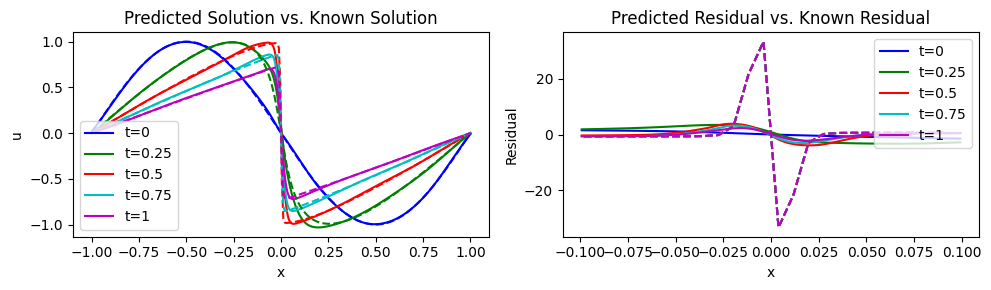

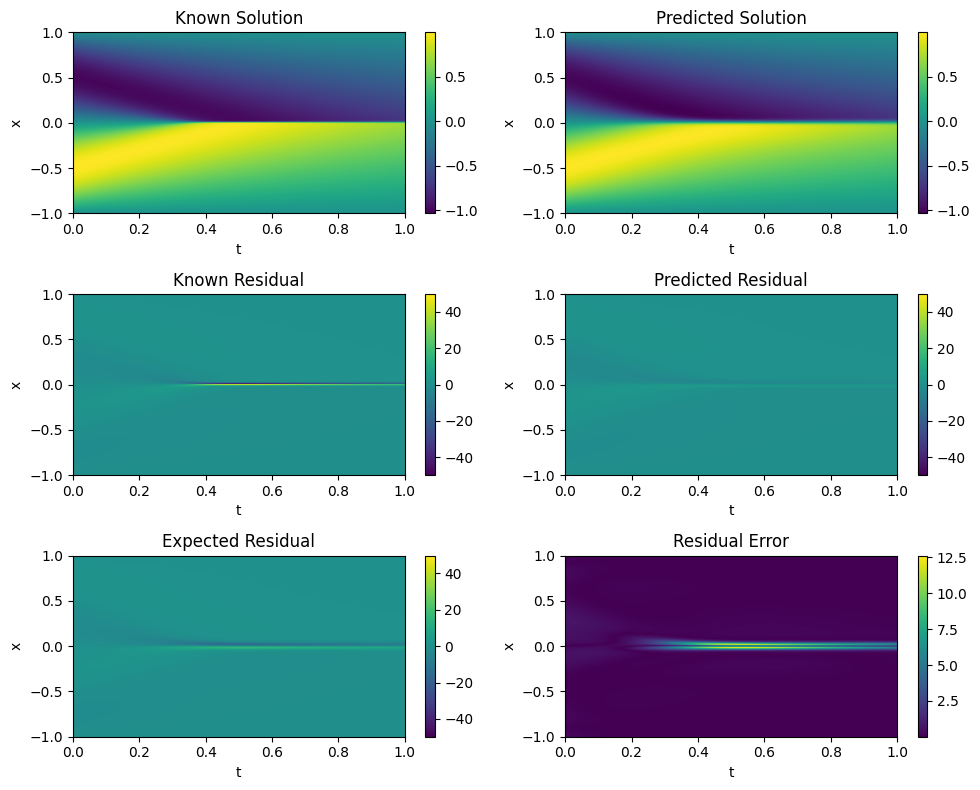

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:26<00:00, 37.56 epoch/s, L=1.53e-02, L_bc=3.16e-04, L_data=2.24e-03, L_pde=3.52e-04]


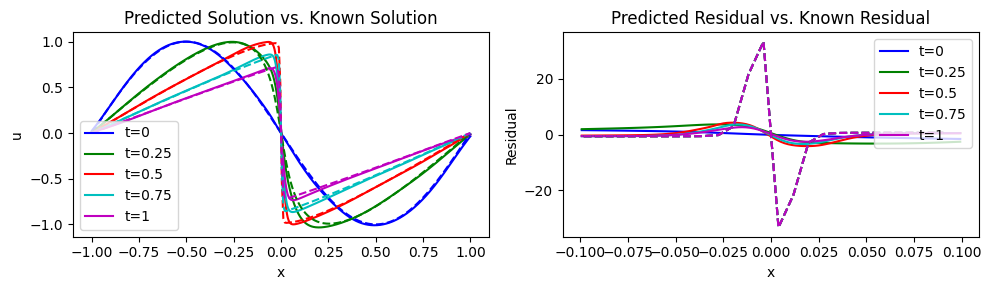

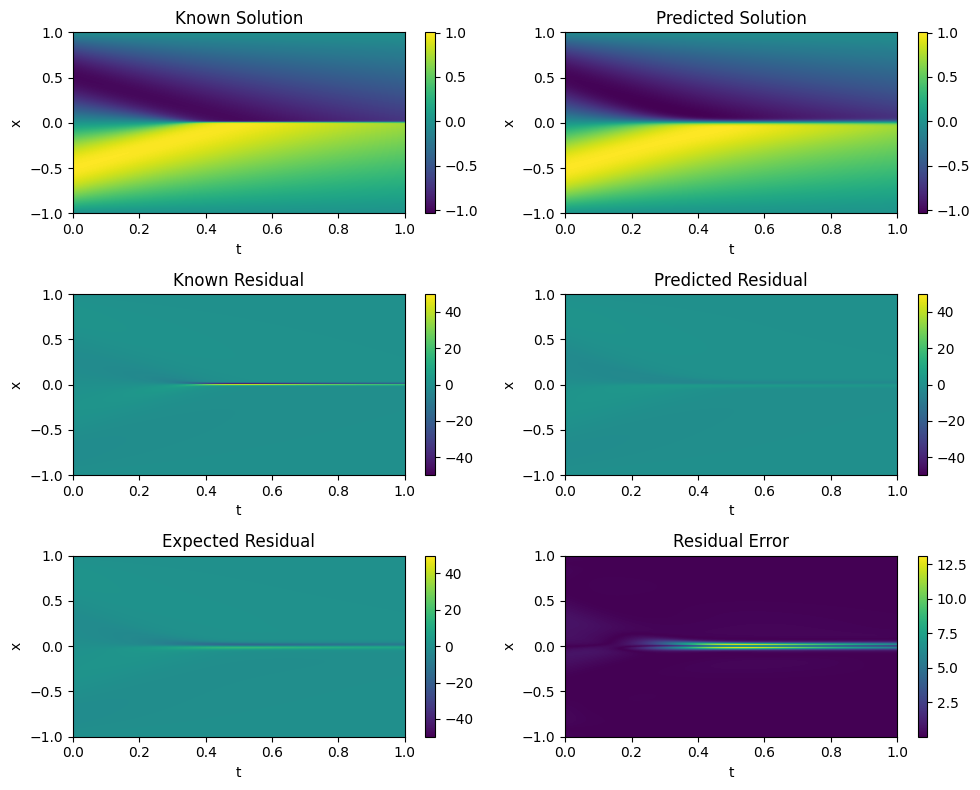

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:24<00:00, 41.61 epoch/s, L=9.65e-03, L_bc=6.46e-06, L_data=1.77e-03, L_pde=8.93e-05]


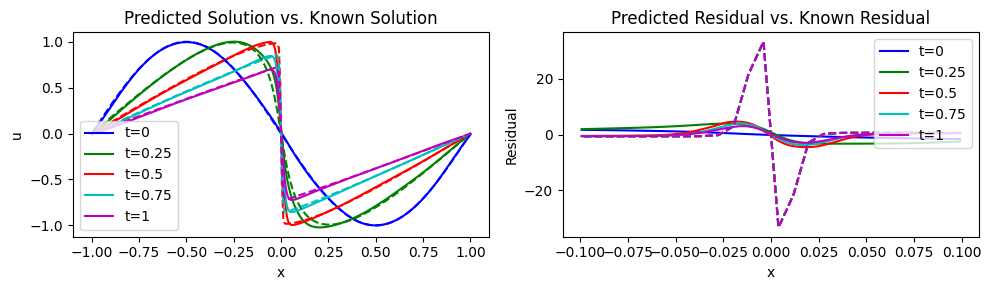

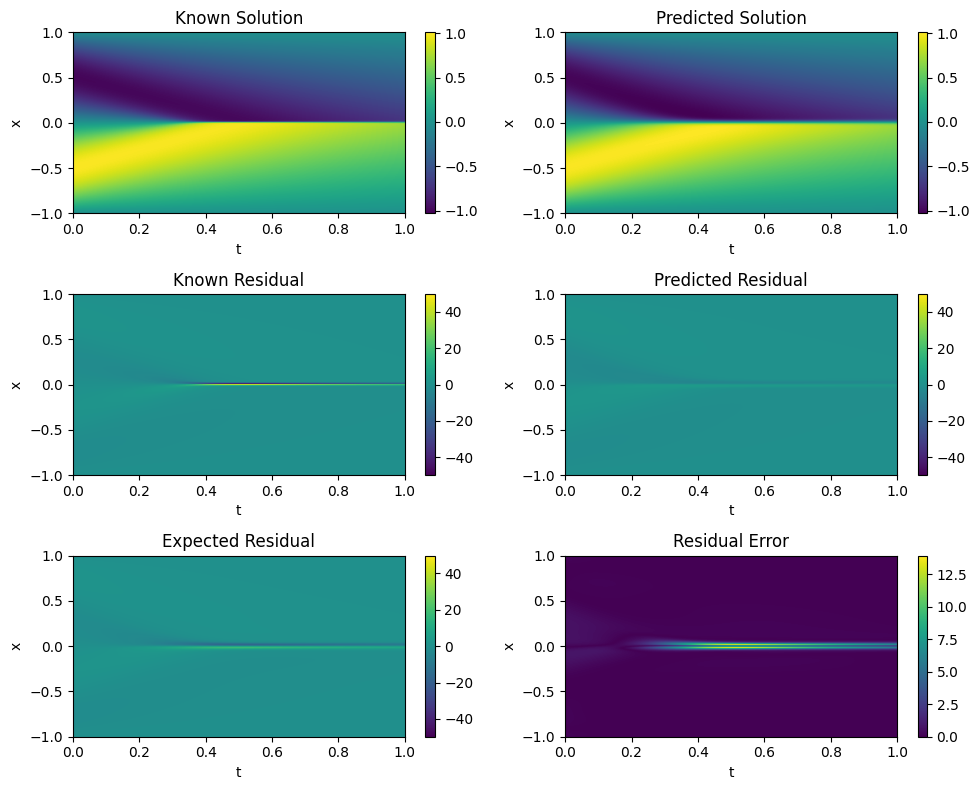

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:23<00:00, 41.93 epoch/s, L=2.04e-02, L_bc=2.51e-04, L_data=1.76e-03, L_pde=1.20e-03]


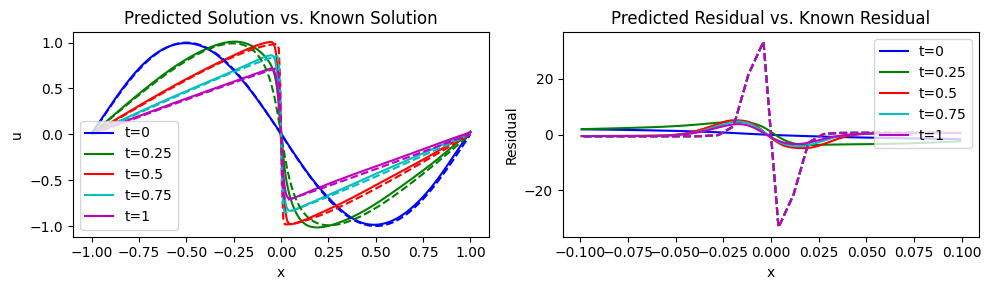

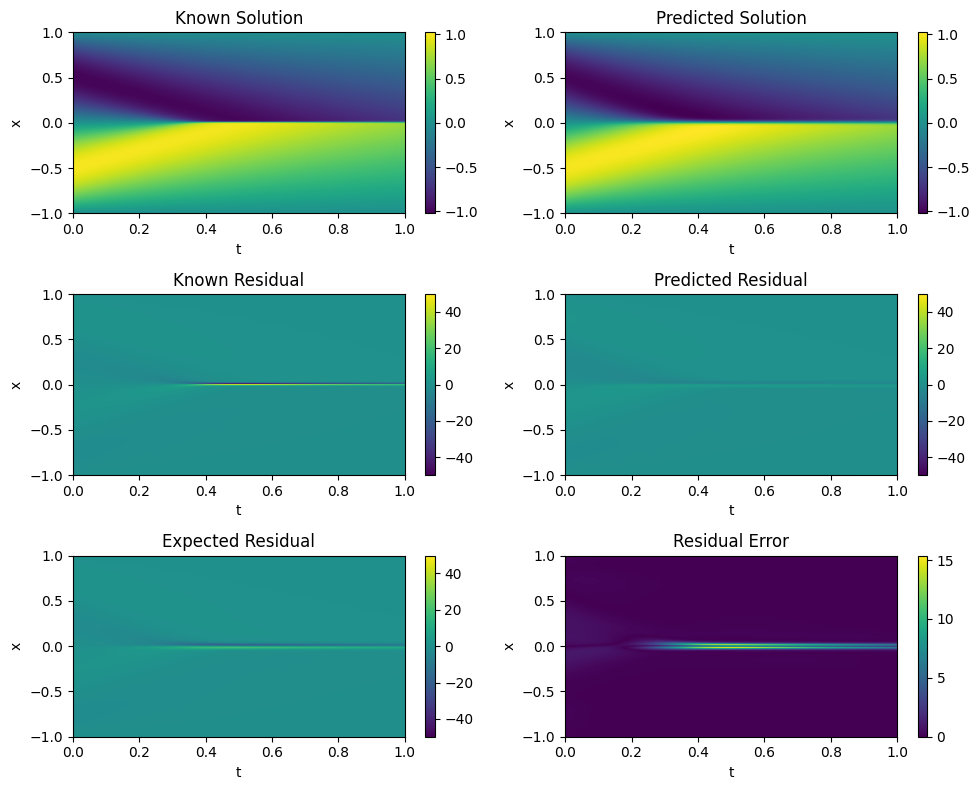

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:24<00:00, 40.37 epoch/s, L=8.88e-03, L_bc=3.02e-05, L_data=1.39e-03, L_pde=2.06e-04]


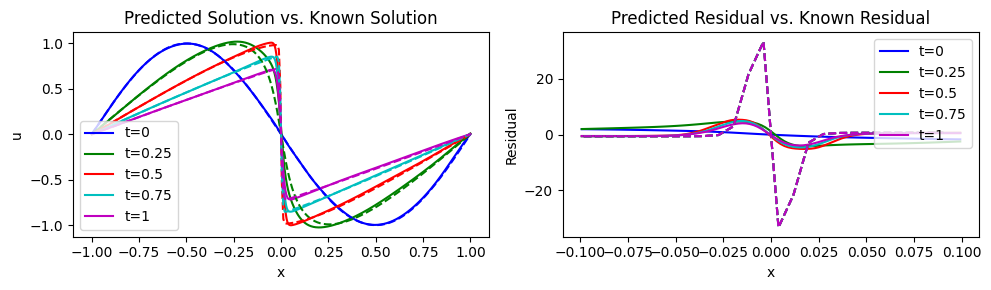

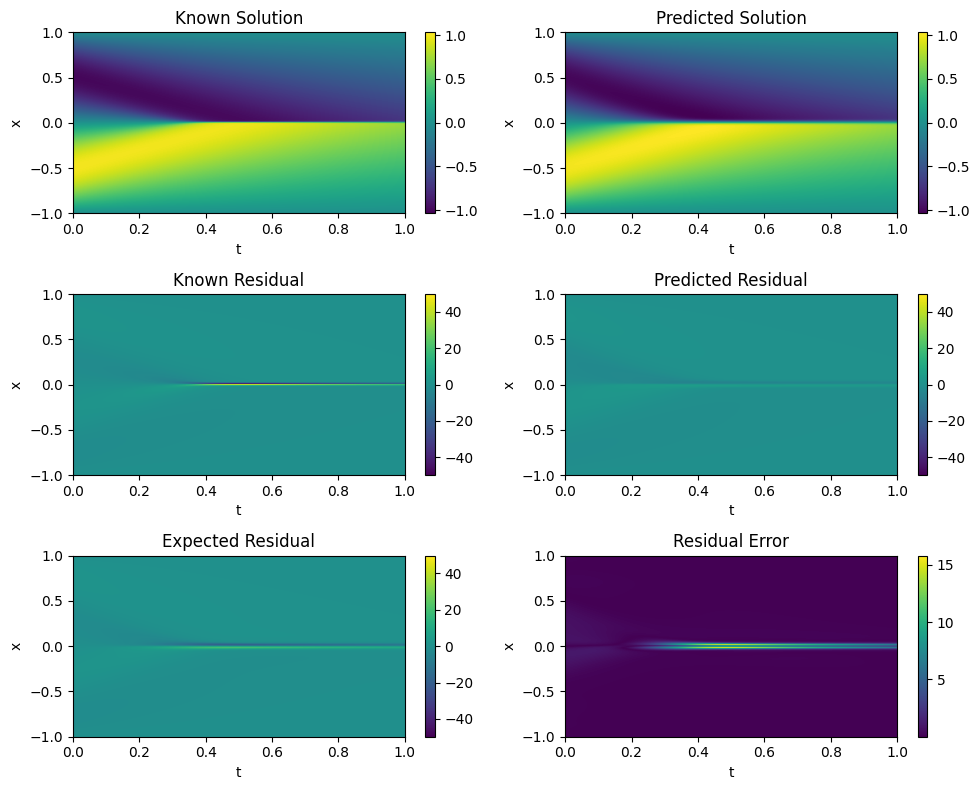

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:24<00:00, 40.08 epoch/s, L=6.49e-03, L_bc=1.74e-06, L_data=1.21e-03, L_pde=4.88e-05]


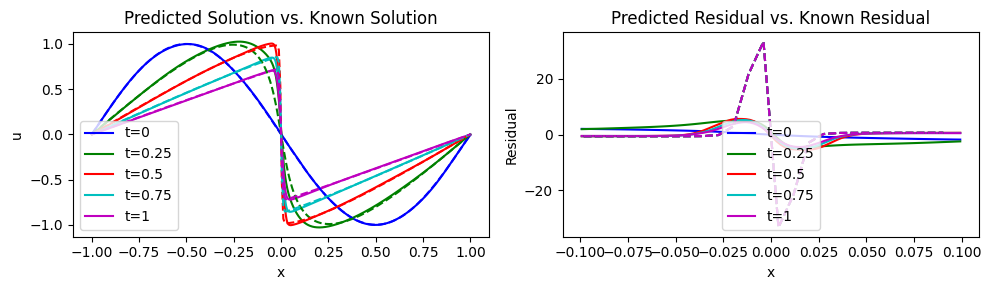

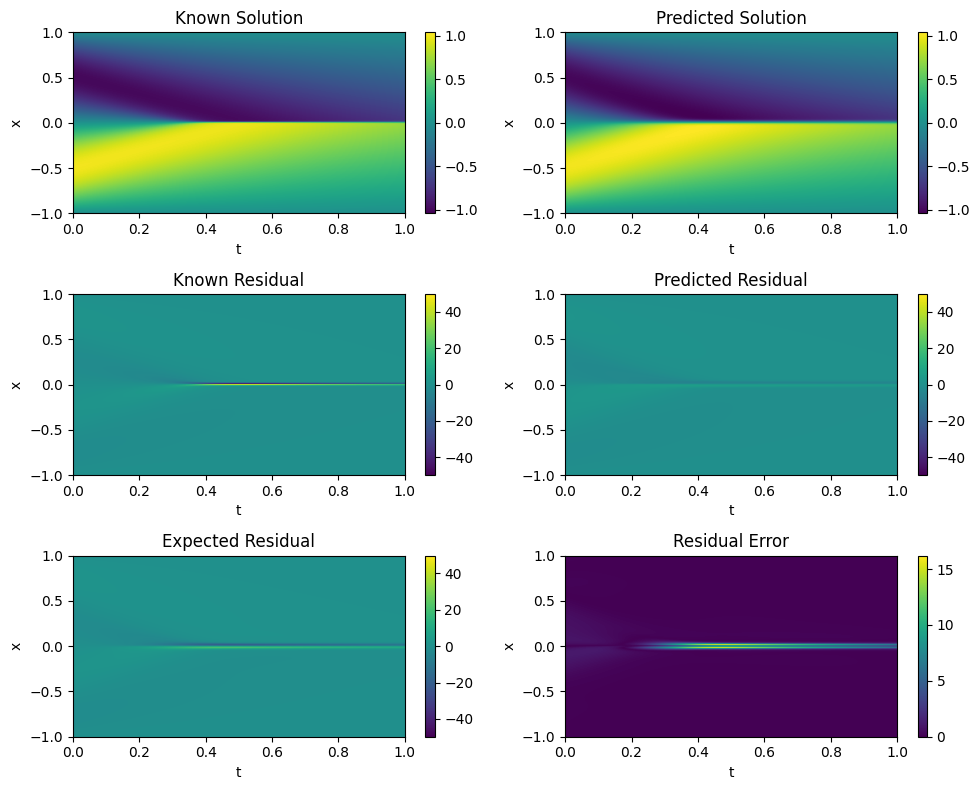

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:24<00:00, 41.38 epoch/s, L=6.69e-03, L_bc=8.71e-06, L_data=1.16e-03, L_pde=9.60e-05]


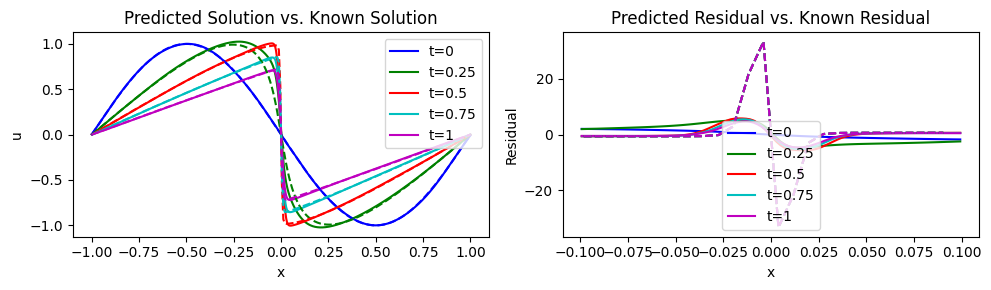

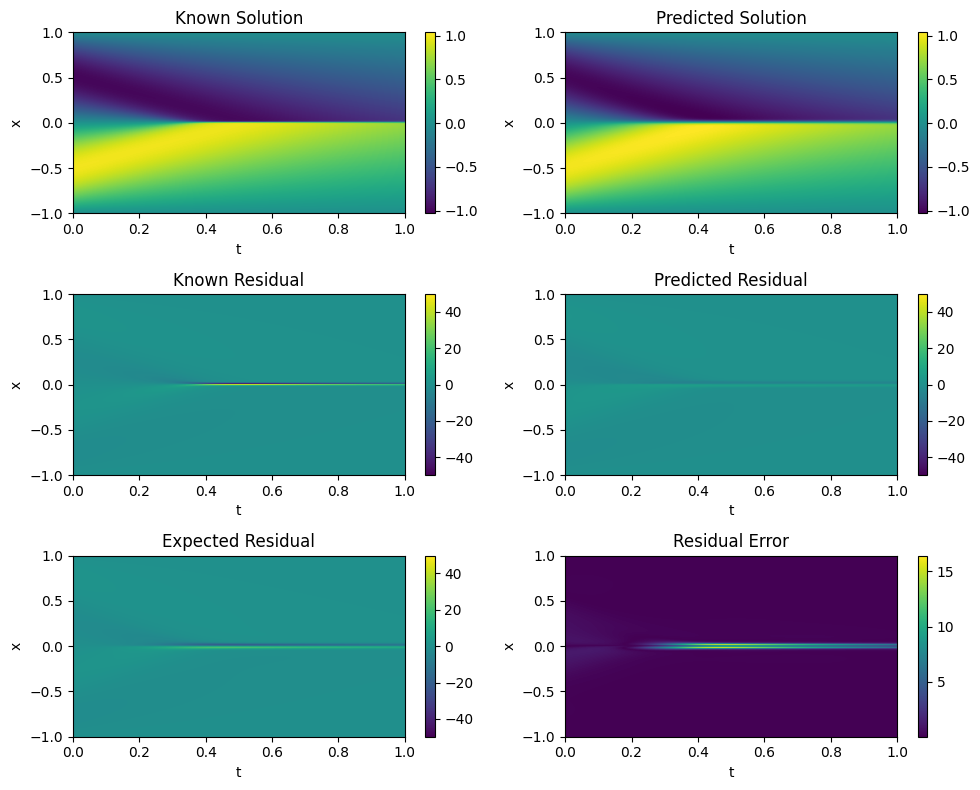

[Info]: Training 1000 epoch(s) on cuda using Adam optimizer.


[CUDA]: 100%|██████████| 1000/1000 [00:24<00:00, 41.44 epoch/s, L=9.26e-03, L_bc=9.67e-05, L_data=1.21e-03, L_pde=3.24e-04]


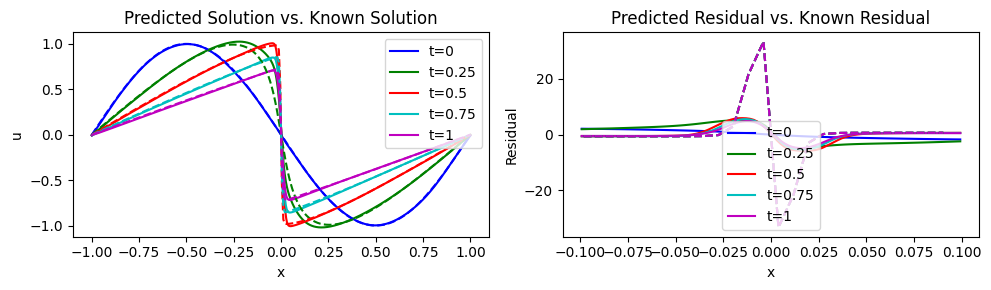

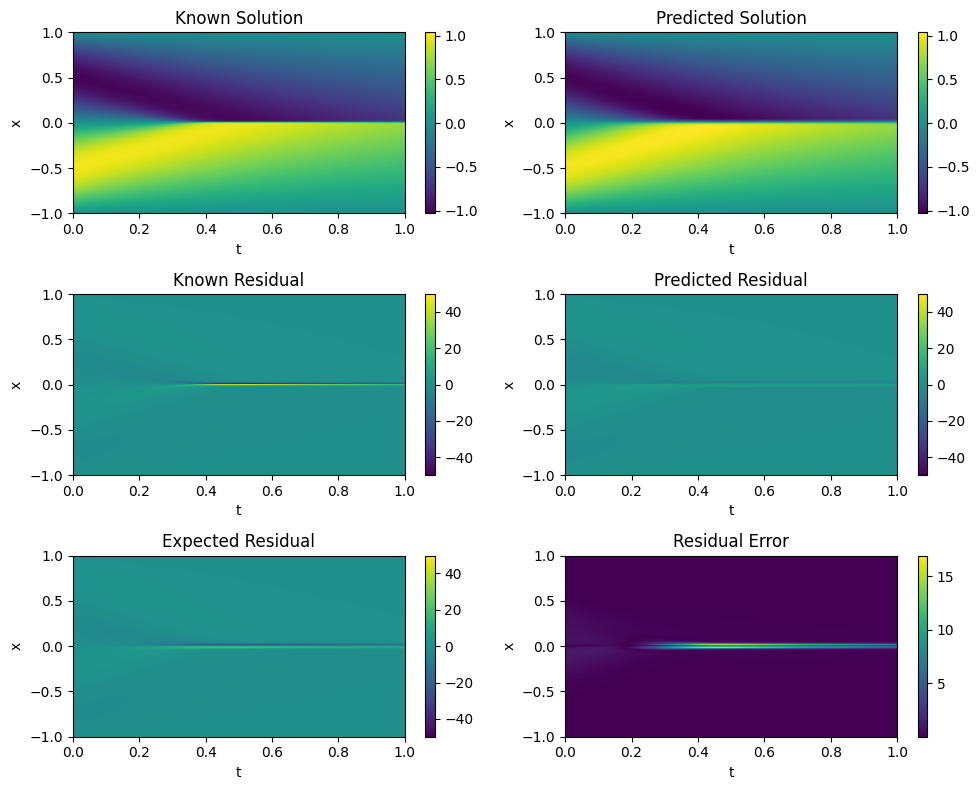

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:30<00:00,  3.33 epoch/s, L=3.83e-03, L_bc=1.79e-06, L_data=6.22e-04, L_pde=7.95e-05]


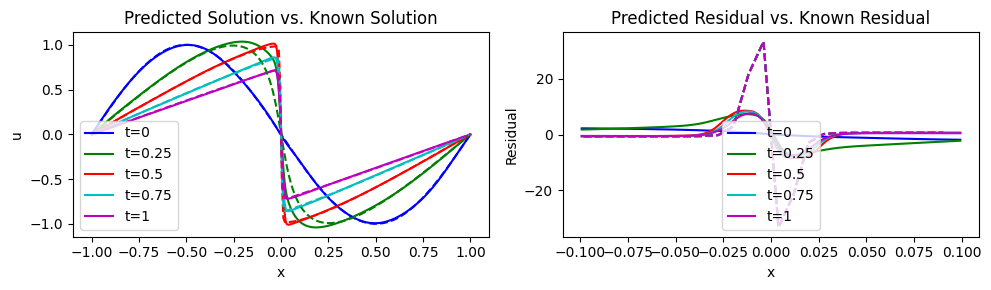

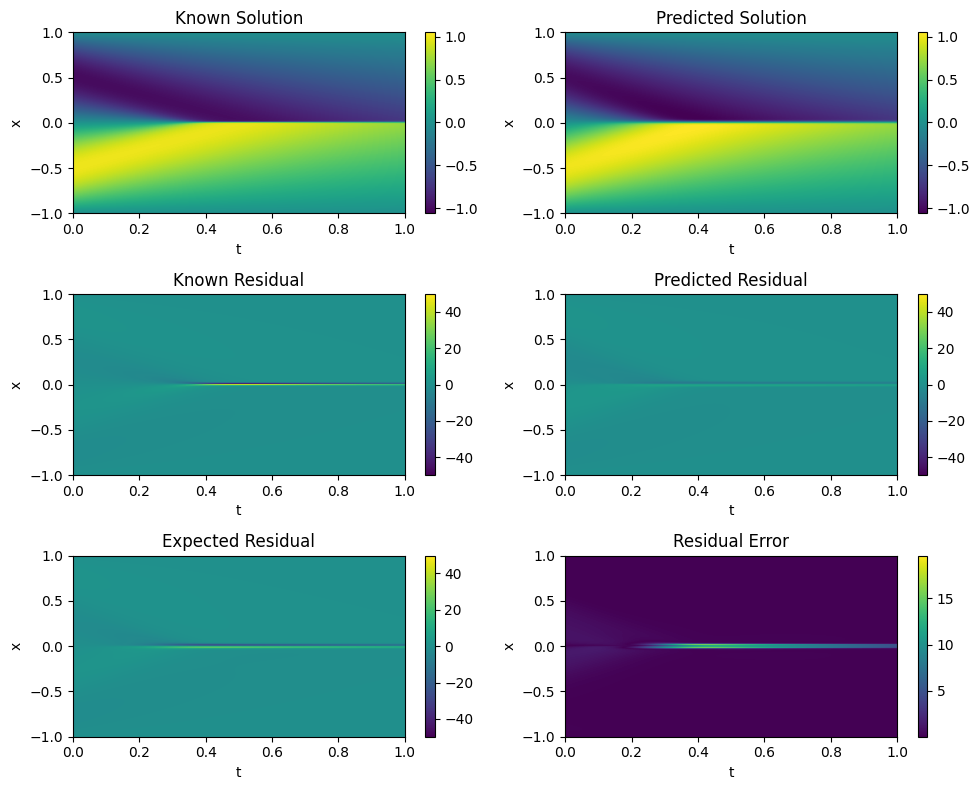

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:32<00:00,  3.08 epoch/s, L=2.29e-03, L_bc=1.17e-06, L_data=3.45e-04, L_pde=6.27e-05]


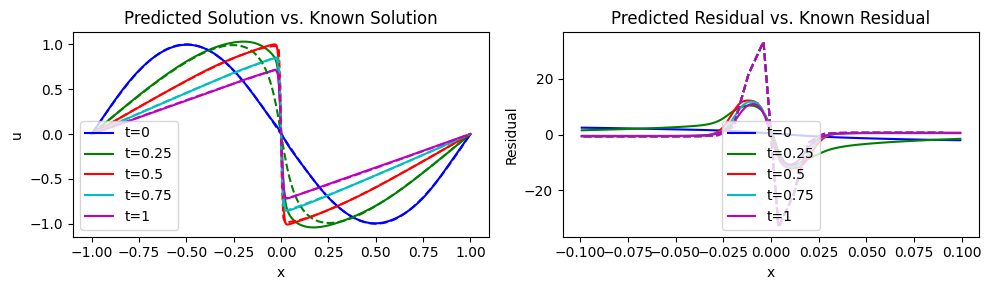

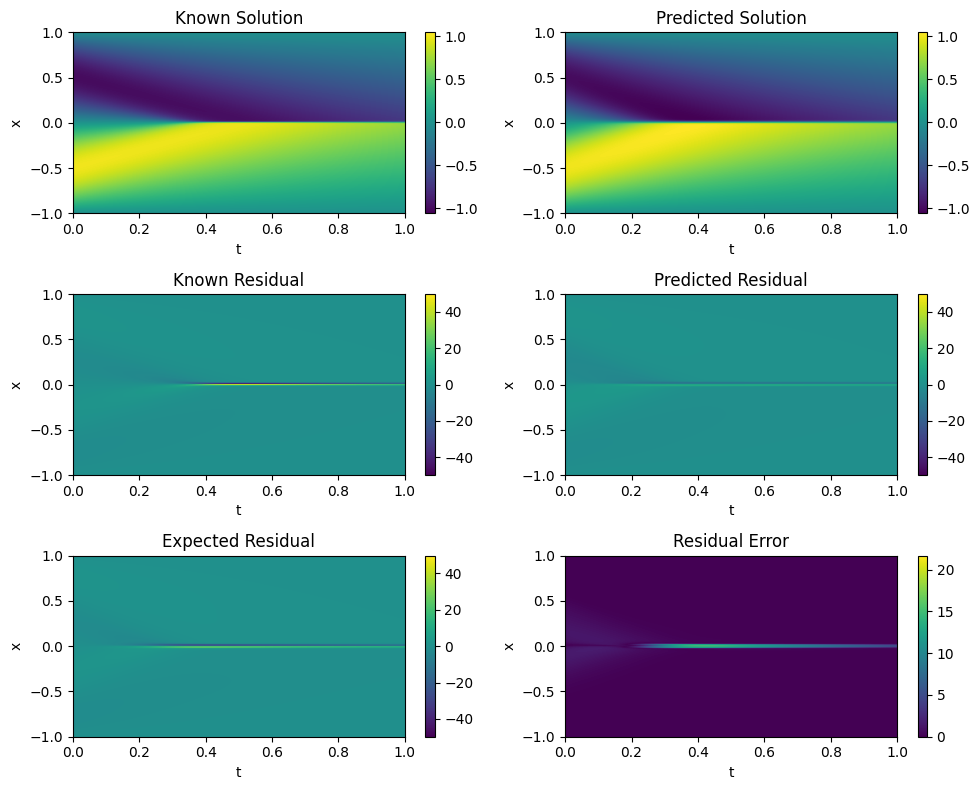

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:30<00:00,  3.29 epoch/s, L=1.66e-03, L_bc=1.15e-06, L_data=2.48e-04, L_pde=4.66e-05]


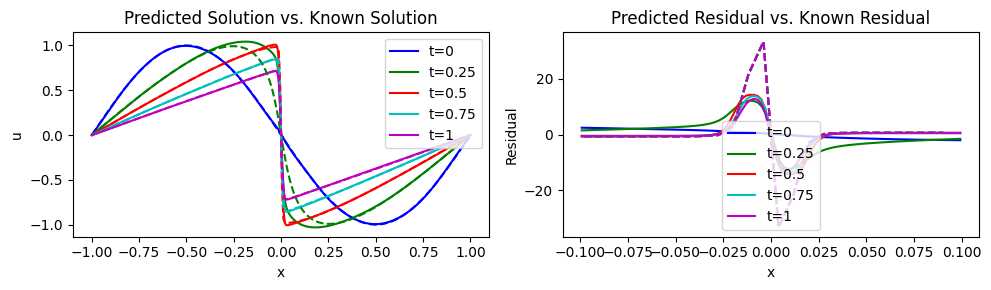

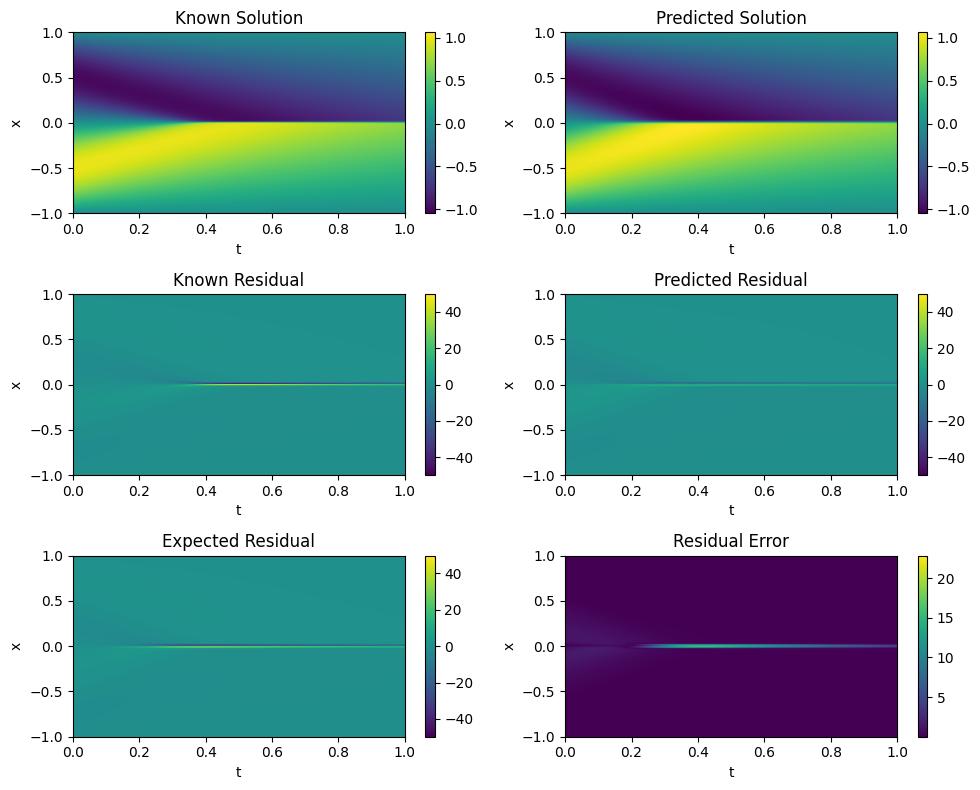

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:31<00:00,  3.21 epoch/s, L=1.31e-03, L_bc=7.90e-07, L_data=2.03e-04, L_pde=3.21e-05]


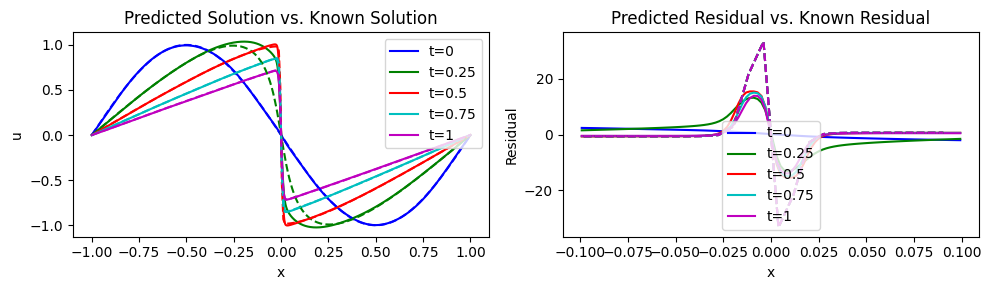

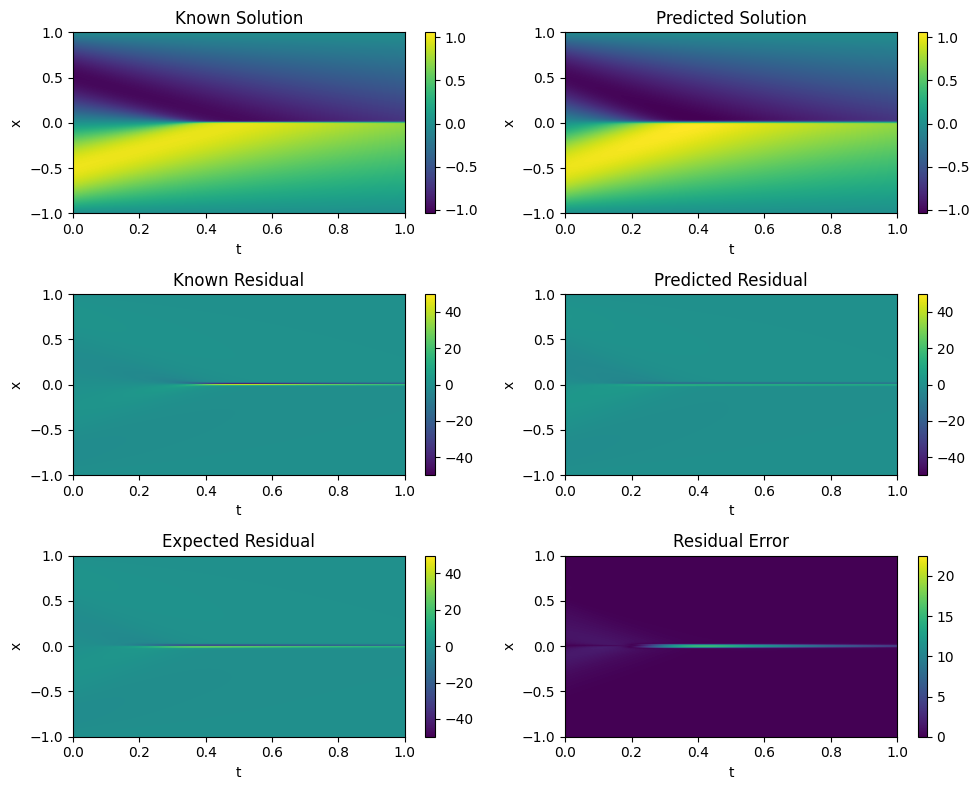

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:31<00:00,  3.20 epoch/s, L=1.07e-03, L_bc=2.92e-07, L_data=1.67e-04, L_pde=2.62e-05]


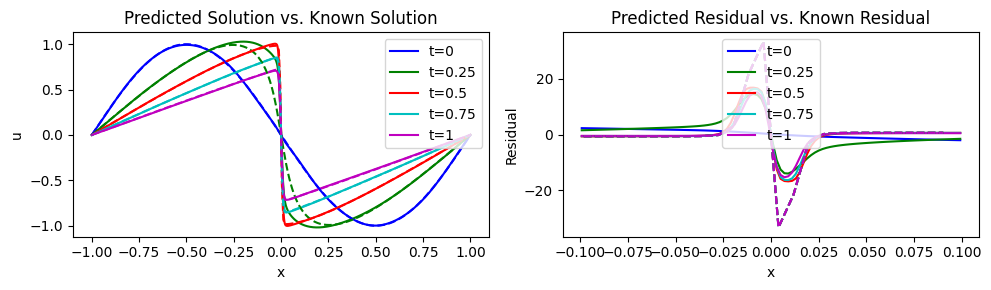

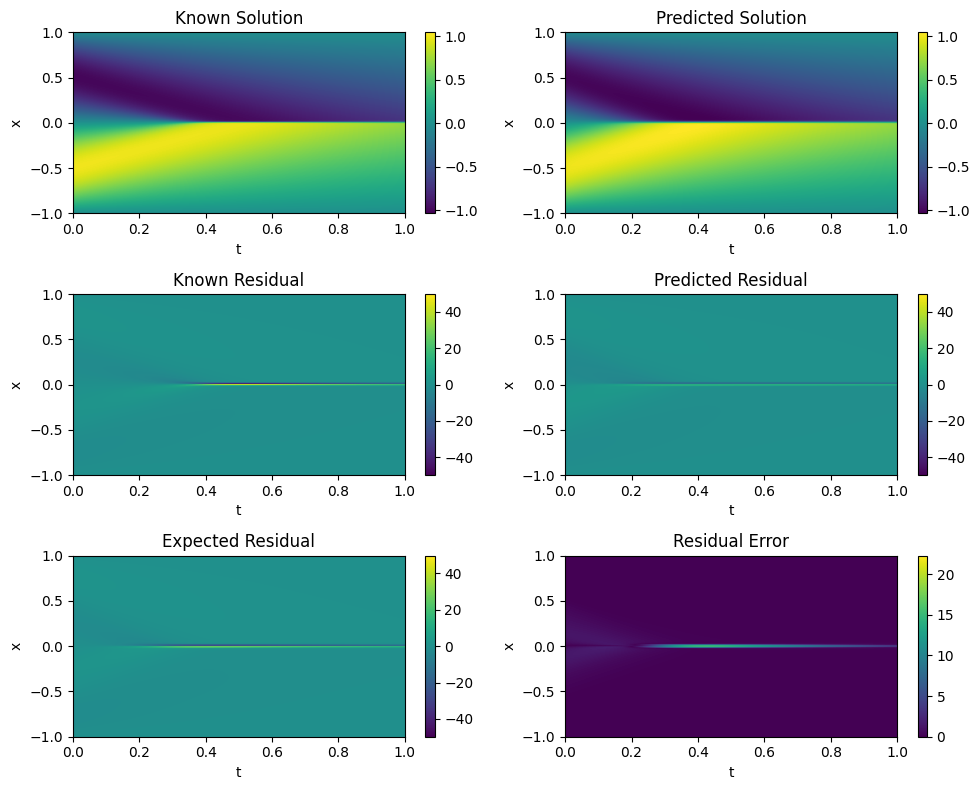

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:31<00:00,  3.19 epoch/s, L=8.99e-04, L_bc=6.09e-07, L_data=1.39e-04, L_pde=2.27e-05]


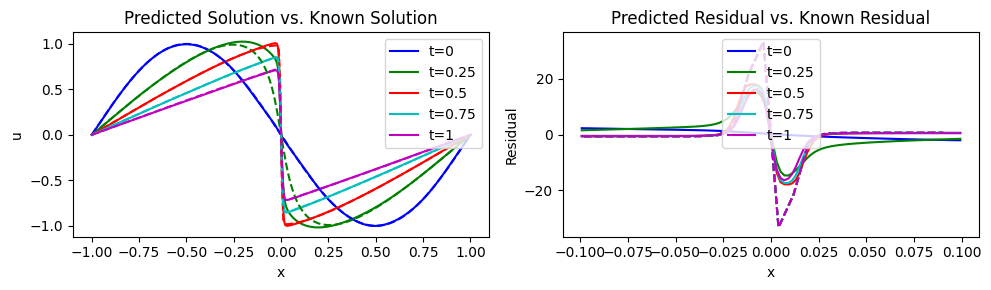

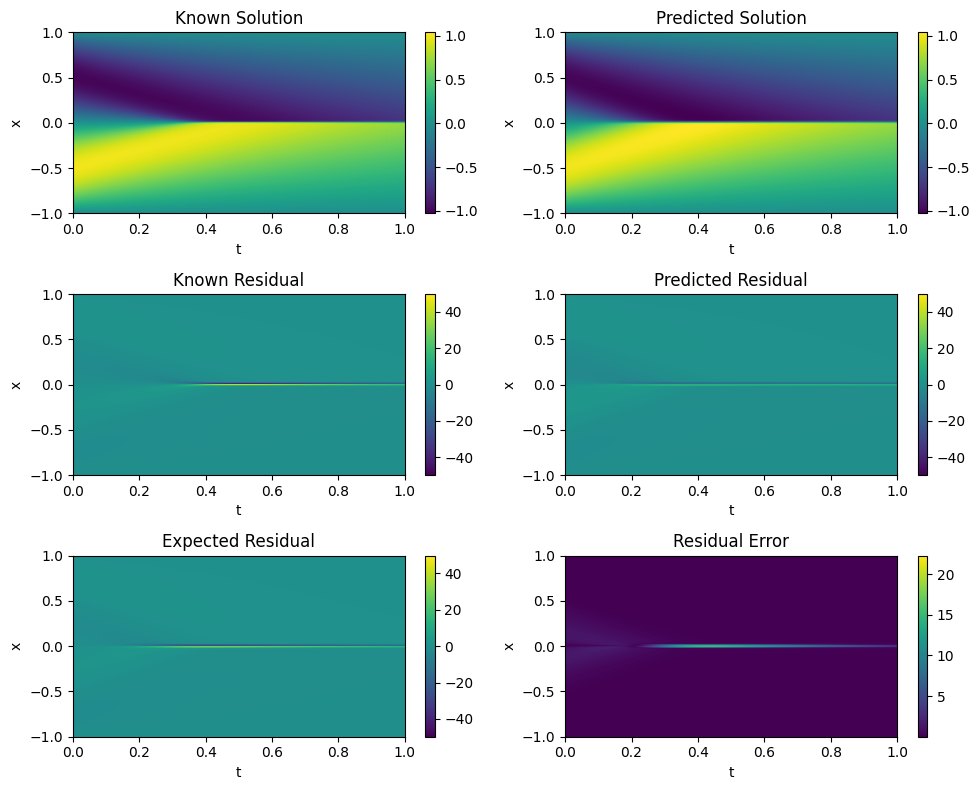

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:31<00:00,  3.16 epoch/s, L=7.88e-04, L_bc=8.16e-07, L_data=1.24e-04, L_pde=1.84e-05]


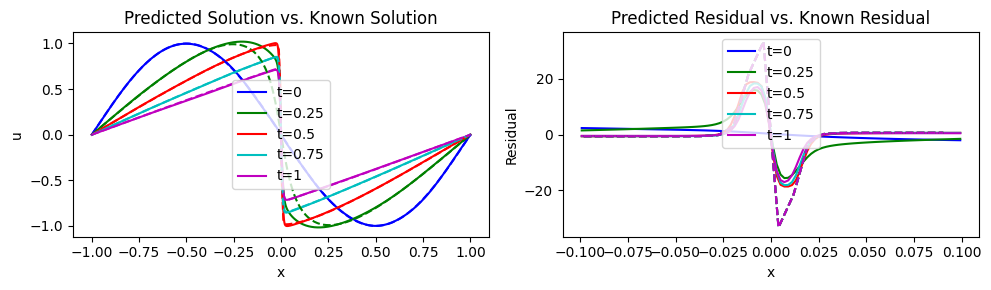

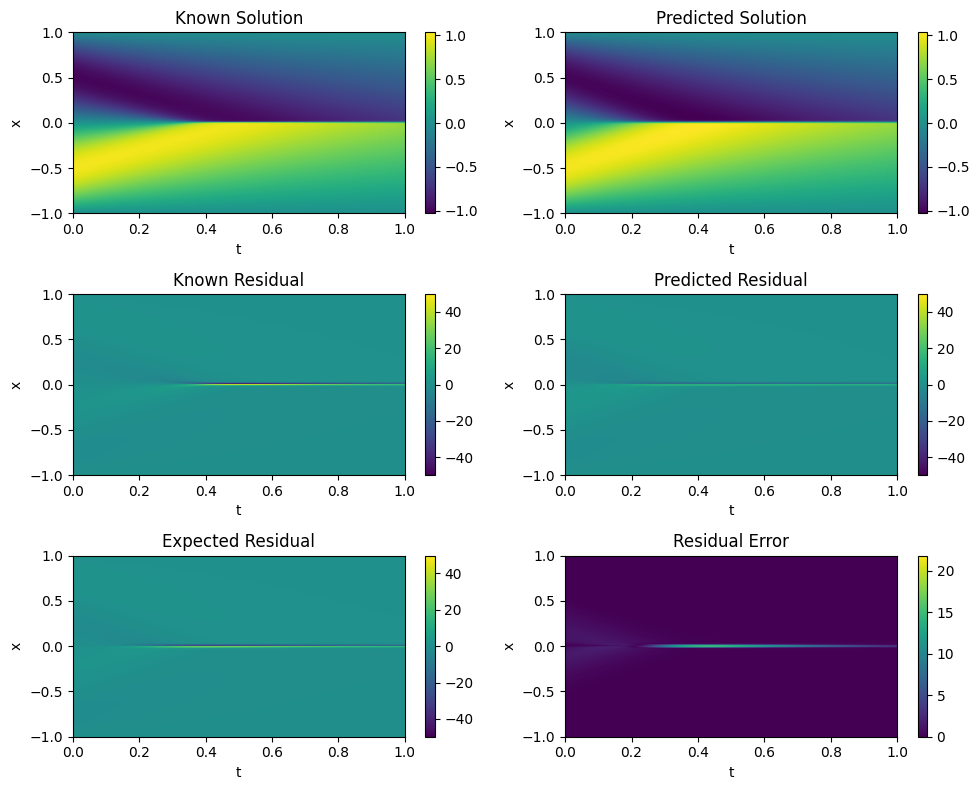

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:31<00:00,  3.19 epoch/s, L=7.19e-04, L_bc=5.93e-07, L_data=1.19e-04, L_pde=1.34e-05]


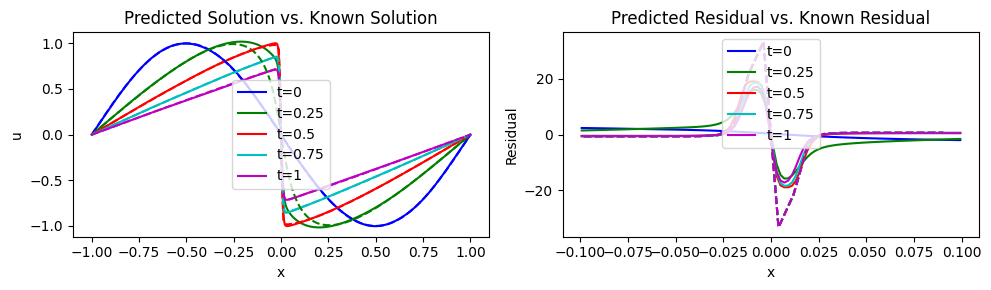

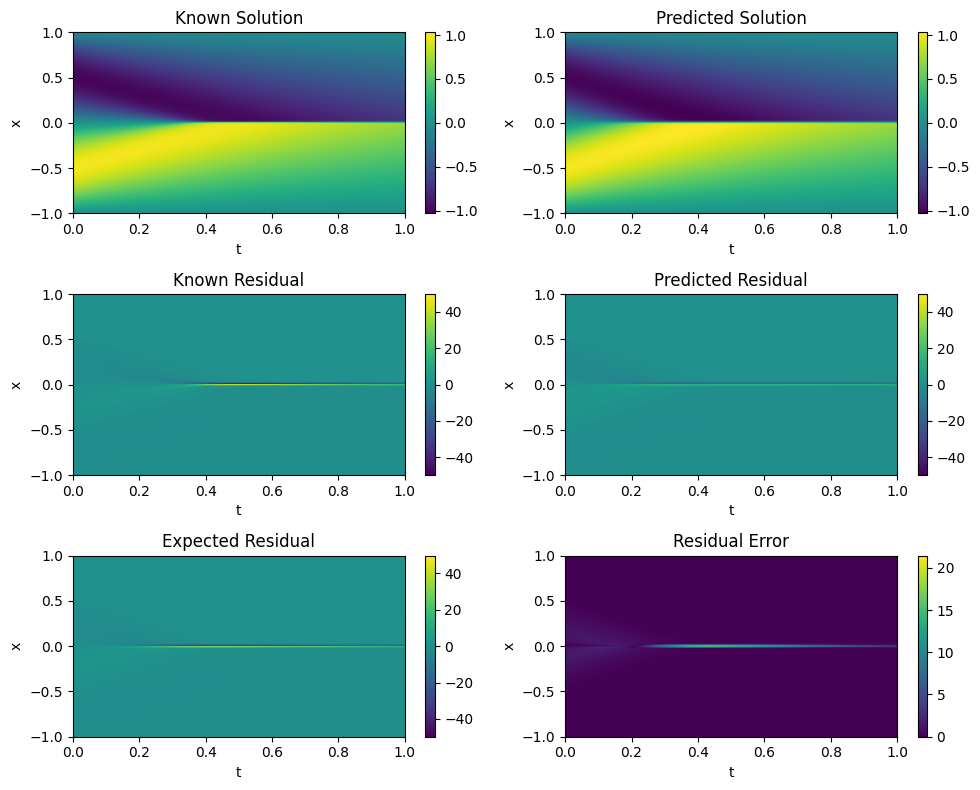

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:30<00:00,  3.26 epoch/s, L=6.77e-04, L_bc=5.17e-07, L_data=1.15e-04, L_pde=1.12e-05]


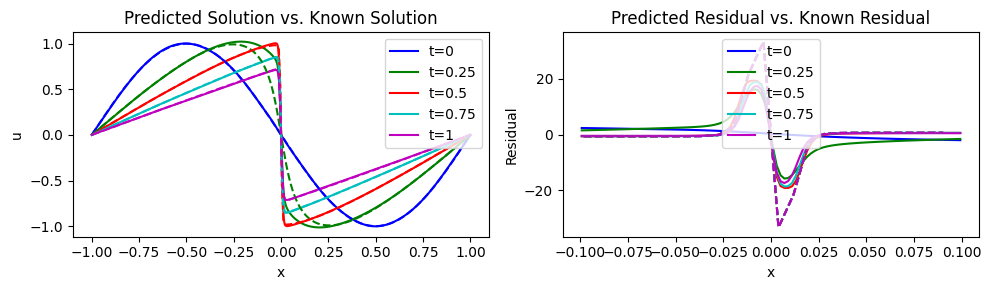

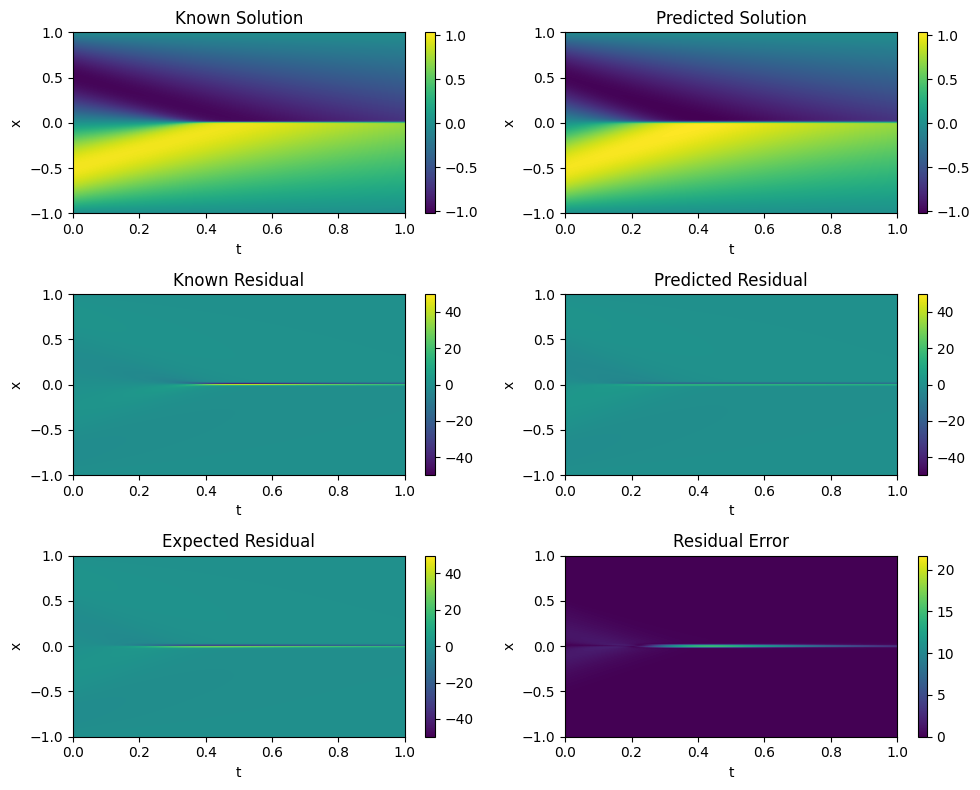

[Info]: Training 100 epoch(s) on cuda using LBFGS optimizer.


[CUDA]: 100%|██████████| 100/100 [00:31<00:00,  3.16 epoch/s, L=6.32e-04, L_bc=3.06e-07, L_data=1.07e-04, L_pde=1.06e-05]


In [10]:
# for _ in range(10):
#     upinn.train_loop(epochs=1000, optimizer=torch.optim.Adam, optimizer_kwargs=dict(lr=1e-3))
#     upinn.train_loop(epochs=1000, optimizer=torch.optim.LBFGS, optimizer_kwargs=dict(max_iter=1))
#     upinn.refine_collocation_points()

# upinn.log_to_wandb=True
# upinn.train_loop(epochs=10000, optimizer=torch.optim.LBFGS, optimizer_kwargs=dict(max_iter=1))
# for _ in range(1):
#     upinn.train_loop(epochs=1000, optimizer=torch.optim.Adam, optimizer_kwargs=dict(lr=1e-3))
#     upinn.train_loop(epochs=100, optimizer=torch.optim.LBFGS, optimizer_kwargs=dict(history_size=10, max_iter=10))
#     upinn.refine_collocation_points()


upinn.optimizer = torch.optim.Adam([{'params': upinn.u.parameters(), 'lr': 3e-3}, {'params': upinn.G.parameters(), 'lr': 2e-3}])
for _ in range(10):
    upinn.plot()
    upinn.train_loop(epochs=1000)

upinn.optimizer = torch.optim.LBFGS([*upinn.u.parameters(), *upinn.G.parameters()], history_size=20, max_iter=10)
for _ in range(10):
    upinn.plot()
    upinn.train_loop(epochs=100)



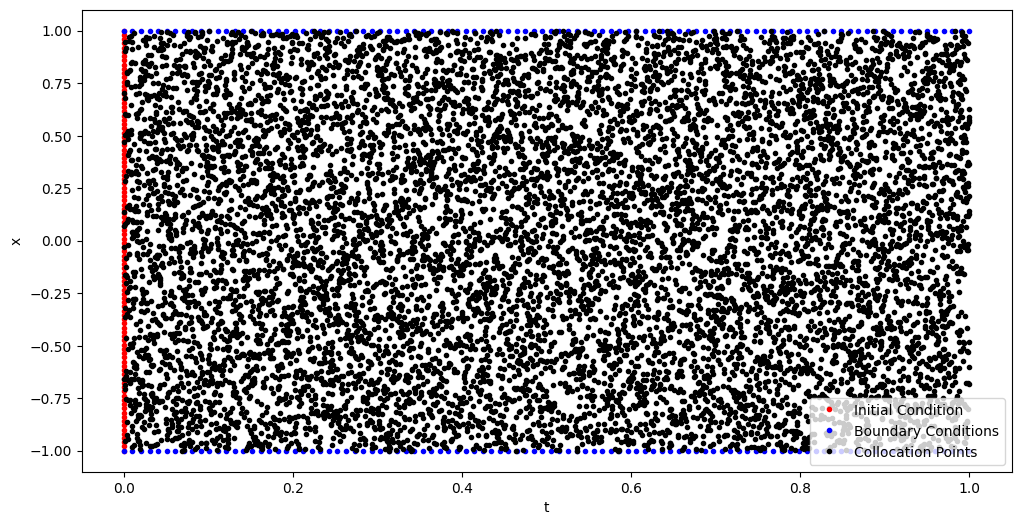

In [11]:
upinn.to('cpu')
# upinn.refine_collocation_points()
# Plot the initial condition, boundary conditions, and collocation points
plt.figure(figsize=(12, 6))
plt.plot(X0[:, 0], X0[:, 1], 'r.', label='Initial Condition')
plt.plot(Xbc[:, 0], Xbc[:, 1], 'b.', label='Boundary Conditions')
plt.plot(upinn.collocation_points[:, 0].detach(), upinn.collocation_points[:, 1].detach(), 'k.', label='Collocation Points')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.show()

### Plot Results

\begin{align}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{align}

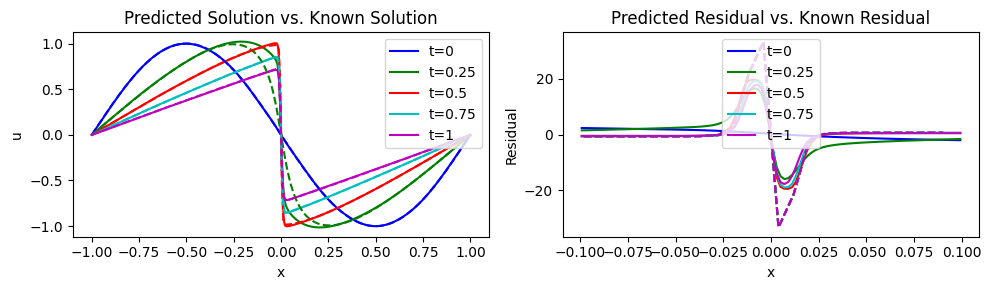

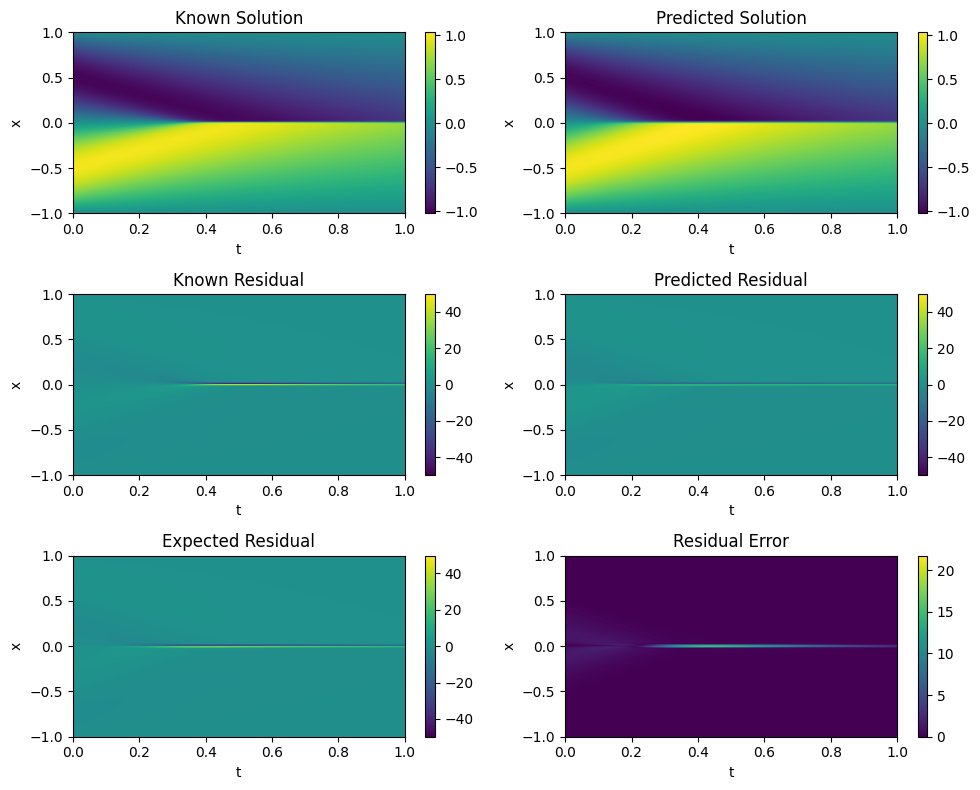

In [12]:
upinn.plot()

### PDE find (SINDy)

In [13]:
import pysindy as ps

In [14]:
t = np.linspace(0, 1, 101)
x = np.linspace(-1, 1, 256)
T, X = np.meshgrid(t, x)

T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
Z_tensor = torch.cat((T_tensor, X_tensor), dim=-1)
Z_tensor.requires_grad_(True)
U_tensor = upinn.u(Z_tensor)
dUdZ = torch.autograd.grad(U_tensor, Z_tensor, torch.ones_like(U_tensor), create_graph=True)[0]
U_t = dUdZ[:, 0:1]
U_x = dUdZ[:, 1:2]
U_dot_tensor = upinn.G(torch.cat((U_tensor, U_t, U_x), dim=-1))
U_dot = U_dot_tensor.detach().numpy().reshape(256, 101, 1)

U = U_tensor.detach().numpy().reshape(256, 101, 1)


# U = data['usol']
# x = data['x']
# # Extract middle slice of 20 points in x
U = U[118:118+20]
U_dot = U_dot[118:118+20]
x = x[118:118+20]
# t = data['t']
# Ux = np.gradient(U, x.squeeze(), axis=0)

# res = U*Ux
# res = res[:, :, None]
# U = U[:, :, None]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=13.0, max_iter=10000, tol=1e-15, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(x=U[:, :80], t=t.flatten()[:80], x_dot=U_dot[:, :80])

model.print()

SR3 model, L0 norm: 
(u)' = -0.640 uu_1


In [15]:
from Utils import SINDy_sklearn

In [16]:
U = data['usol']
x = data['x']
# Extract middle slice of 20 points in x
U = U[118:118+20]
U_dot = U_dot[118:118+20]
x = x[118:118+20]
t = data['t']
Ux = np.gradient(U, x.squeeze(), axis=0)

res = U*Ux
res = res[:, :, None]
U = U[:, :, None]

In [17]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [18]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
model = SINDy_sklearn(feature_names=['x', 'y'], feature_library=ps.PolynomialLibrary(degree=2))
paramgrid = dict(optimizer__threshold=np.linspace(0.01, 1.0, 100))

cv_folds = TimeSeriesSplit(n_splits=10)
model_selector = GridSearchCV(model, param_grid={'optimizer__threshold': np.linspace(0.01, 1.0, 100)}, cv=cv_folds, n_jobs=-1)
model_selector.fit(np.concatenate([t, X], axis=1), X_dot)
best_model = model_selector.best_estimator_

best_model.print()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 100 and the array at index 1 has size 256

In [ ]:
U.shape

(20, 101, 1)

In [ ]:
model.score(x=U[:, 80:], t=t.flatten()[80:], x_dot=U_dot[:, 80:])

0.9476401533425836

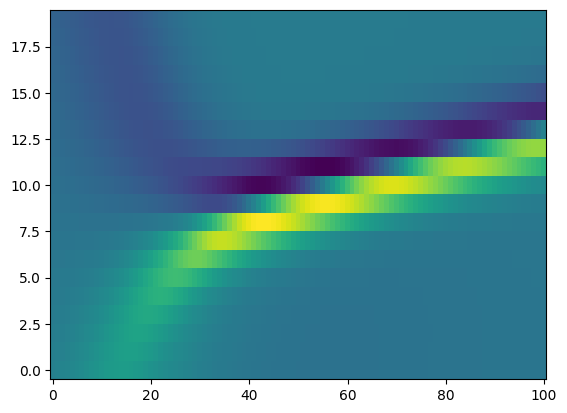

In [ ]:
plt.imshow(U_dot, origin='lower', aspect='auto')